# Multiscale non-Gaussian segmentation

The goal of this tutorial is to introduce the functions of the PYWAVAN library and to demonstrate the capabilities of the Multiscale non-Gaussian segmentation (MnGSeg) technique.

If you do not have the PYWAVAN library, you must clone and install it first:

(you must uncomment the lines while keeping the "!")

In [1]:
#!cd /path_where_you_want_to_clone

#!git clone https://github.com/jfrob27/pywavan.git
#!cd pywavan
#!pip install .

Let's first create a fractional Brownian motion (fBm) map as a simple representation of the interstellar medium.

In [2]:
%pylab inline
from pywavan import fbm2d
#plt.style.use(['dark_background'])

Populating the interactive namespace from numpy and matplotlib


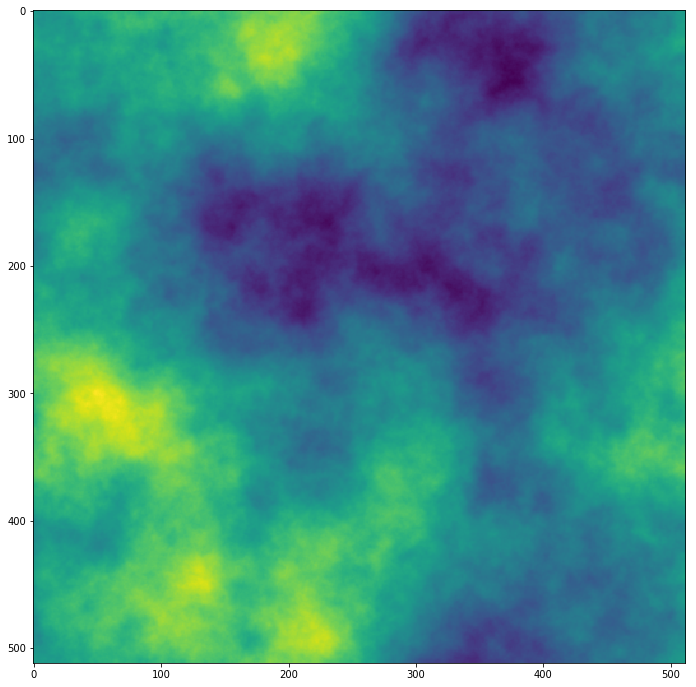

In [3]:
#Create a nx X ny pixels map with a power law gamma
nx = 512
ny = 512
gamma = -3.6
fbm = fbm2d(gamma, ny,nx)

#Display the map
figure(figsize=(12,12))
imshow(fbm)

To this monofractal structure we add artificial filaments.

In [4]:
from scipy.ndimage import rotate
from pywavan import imsmooth

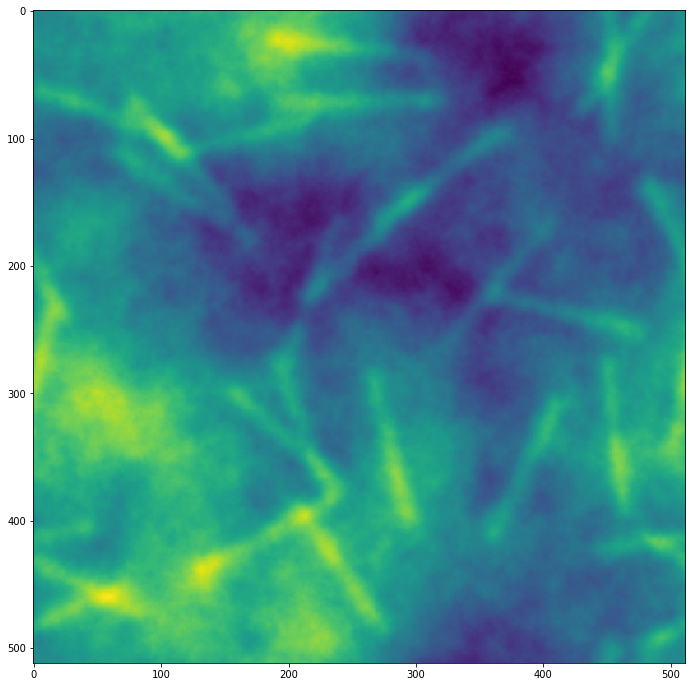

In [5]:
#Filament size and initial position
fsz = 128
pos = np.array([ny/2-1,nx/2-1])

#Number of orientations and filaments
N=25
delt=180/N

#Random shift for the different filaments
shx = np.random.randn(N)*250.
shy = np.random.randn(N)*250.

#Filaments layer
imfiltot = np.zeros((ny,nx))

#Loop to create all filaments
for i in range(N):
    imfil = imfiltot * 0.
    imfil[(pos[0]-fsz/2):(pos[0]+fsz/2)-1,pos[1]] = 1.
    angl = delt*i
    imfil = rotate(imfil,angl,reshape=False)
    imfil = np.roll(imfil,np.int(shx[i]),axis=1)
    imfil = np.roll(imfil,np.int(shy[i]),axis=0)
    imfiltot += imfil
    
#Impose filaments width
FWHM = 15
imfiltot = imsmooth(imfiltot,FWHM)
    
#Create image total
imtot = fbm + imfiltot * 10.
    
#Display the filament layer
figure(figsize=(12,12))
imshow(imtot)

## Fourier power spectrum analysis

Now that we have a mock-ISM, we can analyse its power spectrum.

In [6]:
from pywavan import powspec

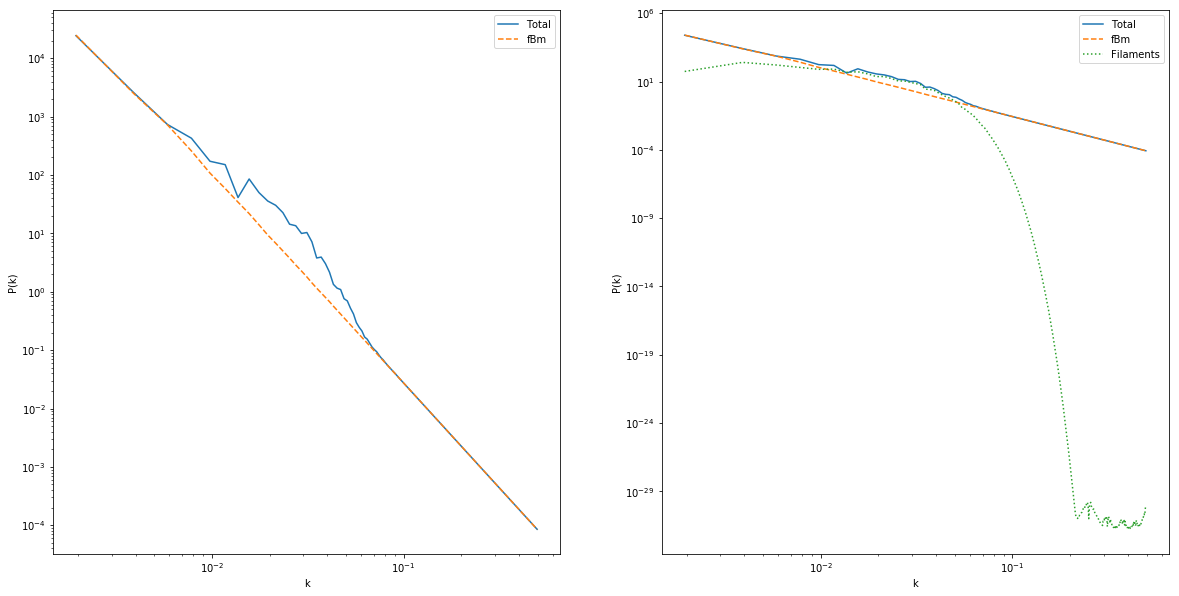

In [7]:
#Calculate the total image Fourier power spectrum
tab_k, spec_ktot = powspec(imtot, reso=1.)

#Calculate the fBm power spectrum only
tab_k, spec_kfbm = powspec(fbm, reso=1.)

#Calculate the filaments power spectrum only
tab_k, spec_kfil = powspec(imfiltot*10., reso=1.)

#Plot the power spectra in log-log
figure(figsize=(20,10))
plt.subplot(1,2,1)
plot(tab_k, spec_ktot, label='Total')
plot(tab_k, spec_kfbm, linestyle='--', label='fBm')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()

plt.subplot(1,2,2)
plot(tab_k, spec_ktot, label='Total')
plot(tab_k, spec_kfbm, linestyle='--', label='fBm')
plot(tab_k, spec_kfil, linestyle=':', label='Filaments')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()

As we can see, the fBm has a unique power law, whereas the random filments have essentially the power spectrum of the Gaussian smoothing kernel. The random mock-filaments create a bump around $2 \times 10^{-2}$ pixel$^{-1}$ in the total power spectrum. In reality, the integration of interstellar filaments to the background is much more complicated. The purpose of this example, is only to introduce the different PYWAVAN functions and to demonstrate the capabilities the Multiscale non-Gaussian Segmentation (MnGSeg) method.

## Wavelet power spectrum analysis

Now, we can apply the segmentation methode in order to separate the two components, i.e. the scale-free fBm and the filaments.

In [8]:
from pywavan import fan_trans

Frist, we will simply reproduce the Fourier power spectrum analysis using the Fan wavelet transform introduced by [Kirby 2005](http://adsabs.harvard.edu/abs/2005CG.....31..846K).

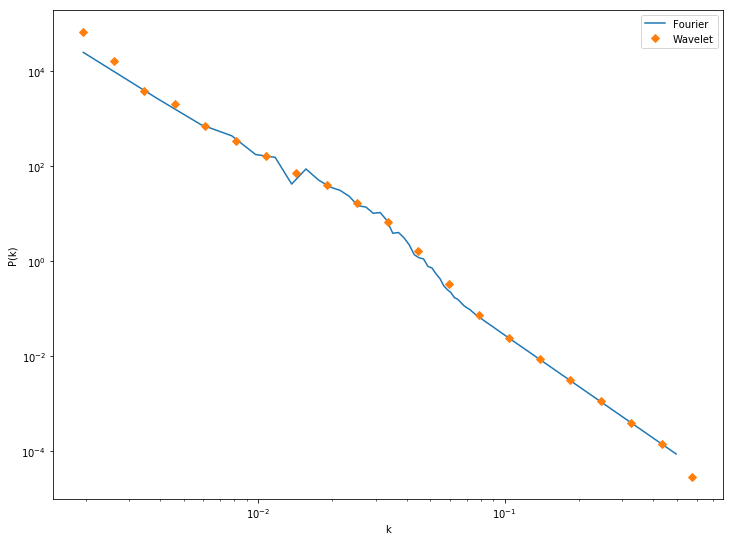

In [9]:
#Calculate the Fan wavelet transforms
wt, S11a, wav_k, S1a, q = fan_trans(imtot, reso=1, q=0, qdyn=False)

#Plot the Fourier and wavelet power spectra
figure(figsize=(12,9))
plot(tab_k, spec_ktot, label='Fourier')
plot(wav_k, S1a, 'D', label='Wavelet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()

We can see that the wavelet power spectrum corresponds very well to the Fourier power spectrum. However, the wavelet power spectrum is much more powerful, because, at every spatial scale $k$, it is now possible to visualize the spatial distribution of the fluctuations.

Here is how the different outputs should interpreted:

$$wt(l,x) = \sum_{\theta} f(x) \circledast \psi(l,x,\theta)$$

where $f(x)$ is the image, $\psi(l,x,\theta)$ is the anisotropic Morlet wavelet as a function of the spatial scale $l$ and angle $\theta$ and $\circledast$ is the convolution operation. The Fan wavelet represents the summation of multiple Morlet wavelet transforms over the azimythal angles $\theta$. And for the other outputs:

$$S11a(l,x) = \sum_{\theta} |f(x) \circledast \psi(l,x,\theta)|^2$$

$$S1a(l) = \sum_{x}\sum_{\theta} |f(x) \circledast \psi(l,x,\theta)|^2$$

The spatial scales $l$ are normalised to correspond to the wavenumbers $k$ in the Fourier space and are stored in wav_k.

Let's have a look at S11a for different wavenumber $k$.

Text(0.5,1,u'k=0.18462410754524675')

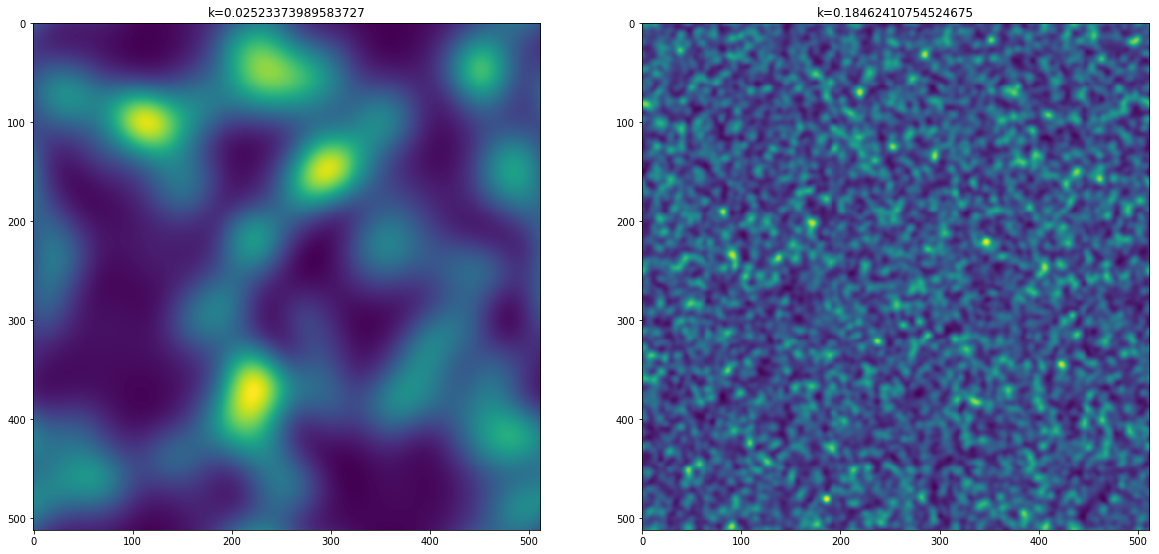

In [10]:
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(S11a[9,:,:])
plt.title('k='+np.str(wav_k[9]))

plt.subplot(1,2,2)
imshow(S11a[16,:,:])
plt.title('k='+np.str(wav_k[16]))

So, according to the power spectra calculated above, the filaments are dominating around the scale $k \approx 0.025$ pixel$^{-1}$ and the scale-free medium is dominating at scales $k > 0.08$ pixel$^{-1}$. Images above show that fluctuations are indeed dominated by the filaments at $k = 0.025$ pixel$^{-1}$ and by random noise at $k = 0.18$ pixel$^{-1}$.

The MnGSeg technique is looking at the structures that do not correspond to a random distribution as a function of scales and azimuthal angles. To perform this segmentation, we also use the **fan_trans** function, but with additionnal options.

In [11]:
M = np.size(wav_k)

#Set a list of q that are all starting at 2.5
#The q parameter sets the "sensitivity" to non-Gaussianities in a distribution
q=[]
q=[2.5]*M


#Wavelet power spectrum where the q parameter is dynamic and will converge
#to its optimal value as a function of scales and angles according to the skewness
#of the wavelet coefficients distribution.
wt, S11a, wav_k, S1a, q = fan_trans(imtot, reso=1, q=q, qdyn=True, skewl=0.4)

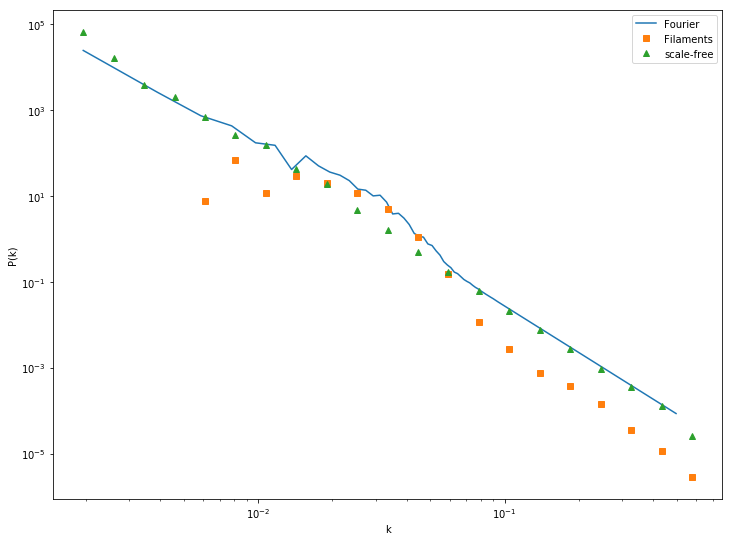

In [12]:
#Plot the segmented power spectra
figure(figsize=(12,9))
plot(tab_k, spec_ktot, label='Fourier')
plot(wav_k, S1a[1,:], 's', label='Filaments')
plot(wav_k, S1a[2,:], '^', label='scale-free')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()

The MnGSeg algorithm succeeded to retrieve the flat fBm power spectrum for the scale-free part of the image. The filaments power spectrum corresponds also very well to the original one except at smaller scales where the scale-free part is largely dominating.

Both components can also be easily reconstructed from the real part of the wavelet coefficients.

Text(0.5,1,u'Scale-free fractal simulation')

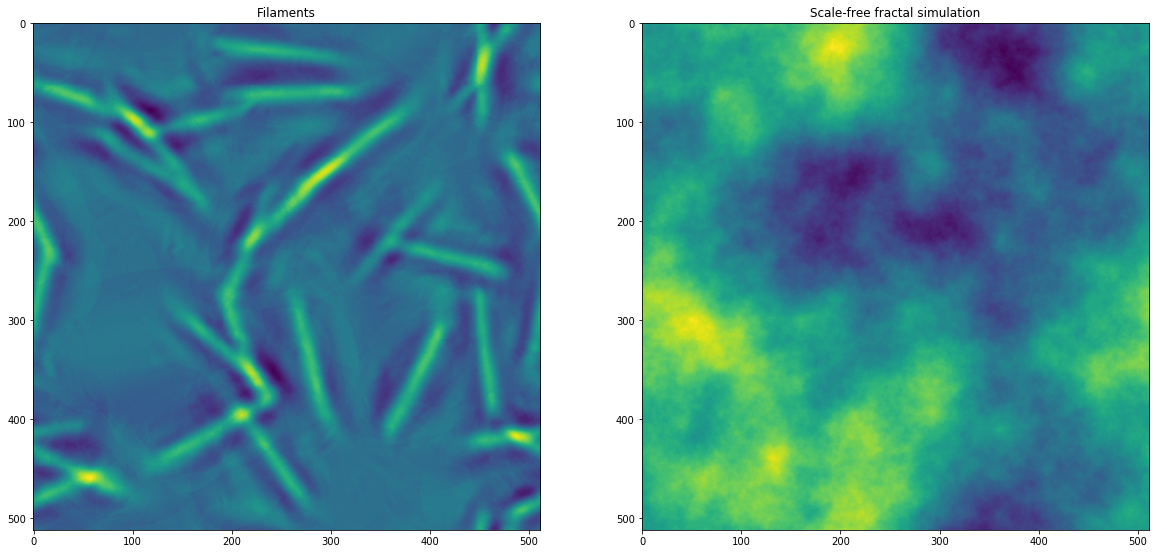

In [13]:
#Image reconstruction from the segmented wavelet coefficients
filaments = np.sum(wt[M:2*M,:,:].real,axis=0)
scale_free = np.sum(wt[2*M:3*M,:,:].real,axis=0)

#Plot images
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(filaments)
plt.title('Filaments')

plt.subplot(1,2,2)
imshow(scale_free)
plt.title('Scale-free fractal simulation')